### Example Dataframe


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from pydicom import dcmread
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from PIL import Image, ImageOps


DATA_DIR = "C:/Users/DryLab/Desktop/villa/data/open-i"

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create a DataFrame


In [3]:
image_dir = "C:/Users/DryLab/Downloads/NLMCXR_dcm"
image_paths = sorted(
    [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)],
    key=lambda x: int(os.path.basename(x).split("\\")[-1]),
)

In [4]:
dataframe = []

image_id = 0

for image_path in tqdm(image_paths):
    # Check directory
    if os.path.isdir(image_path):
        for i in os.listdir(image_path):
            dataframe.append(
                {"image_id": image_id, "image_path": os.path.join(image_path, i)}
            )
            image_id += 1

  0%|          | 0/3851 [00:00<?, ?it/s]

100%|██████████| 3851/3851 [00:00<00:00, 23804.02it/s]


In [5]:
df = pd.DataFrame(dataframe)

In [6]:
df

,image_id,image_path
0,0,C:/Users/DryLab/Downloads/NLMCXR_dcm\1\1_IM-00...
1,1,C:/Users/DryLab/Downloads/NLMCXR_dcm\1\1_IM-00...
2,2,C:/Users/DryLab/Downloads/NLMCXR_dcm\2\2_IM-06...
3,3,C:/Users/DryLab/Downloads/NLMCXR_dcm\2\2_IM-06...
4,4,C:/Users/DryLab/Downloads/NLMCXR_dcm\3\3_IM-13...
...,...,...
7465,7465,C:/Users/DryLab/Downloads/NLMCXR_dcm\3997\3997...
7466,7466,C:/Users/DryLab/Downloads/NLMCXR_dcm\3998\3998...
7467,7467,C:/Users/DryLab/Downloads/NLMCXR_dcm\3998\3998...
7468,7468,C:/Users/DryLab/Downloads/NLMCXR_dcm\3999\3999...


In [7]:
text_dir = "C:/Users/DryLab/Downloads/ecgen-radiology-txt"

text_paths = sorted(
    os.listdir(text_dir),
    key=lambda filename: int(filename.split("_")[0].replace("CXR", "")),
)

In [8]:
# Define the directories
image_dir = "C:/Users/DryLab/Downloads/NLMCXR_dcm"
text_dir = "C:/Users/DryLab/Downloads/ecgen-radiology-txt"

# Recursively list all image files
image_files = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith(".dcm"):
            image_files.append(os.path.join(root, file))

# List all text files in the text directory
text_files = [f for f in os.listdir(text_dir) if f.endswith(".txt")]


# Function to extract identifiers
def extract_image_identifier(filepath):
    # Extracts '1_IM-0001-3001' from 'C:/Users/DryLab/Downloads/NLMCXR_dcm/1/1_IM-0001-3001.dcm'
    return os.path.basename(filepath).replace(".dcm", "")


def extract_text_identifier(filename):
    # Extracts '1_IM-0001-3001' from 'CXR1_1_IM-0001-3001.txt'
    return filename.replace("CXR", "").replace(".txt", "")


# Create sets of identifiers
image_ids = set(extract_image_identifier(f) for f in image_files)
text_ids = set(extract_text_identifier(f) for f in text_files)

# Find image identifiers that do not have corresponding text identifiers
missing_text_ids = image_ids - text_ids

# Find image files corresponding to missing text identifiers
missing_text_files = [
    f for f in image_files if extract_image_identifier(f) in missing_text_ids
]

print(f"Total images without corresponding text: {len(missing_text_files)}")


Total images without corresponding text: 40


In [9]:
df = df[~df["image_path"].apply(extract_image_identifier).isin(missing_text_ids)]

In [10]:
df["text_path"] = [os.path.join(text_dir, path) for path in text_paths]

C:\Users\DryLab\AppData\Local\Temp\ipykernel_31704\1738650729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_path"] = [os.path.join(text_dir, path) for path in text_paths]


In [11]:
df

,image_id,image_path,text_path
0,0,C:/Users/DryLab/Downloads/NLMCXR_dcm\1\1_IM-00...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...
1,1,C:/Users/DryLab/Downloads/NLMCXR_dcm\1\1_IM-00...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...
2,2,C:/Users/DryLab/Downloads/NLMCXR_dcm\2\2_IM-06...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...
3,3,C:/Users/DryLab/Downloads/NLMCXR_dcm\2\2_IM-06...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...
4,4,C:/Users/DryLab/Downloads/NLMCXR_dcm\3\3_IM-13...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...
...,...,...,...
7465,7465,C:/Users/DryLab/Downloads/NLMCXR_dcm\3997\3997...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...
7466,7466,C:/Users/DryLab/Downloads/NLMCXR_dcm\3998\3998...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...
7467,7467,C:/Users/DryLab/Downloads/NLMCXR_dcm\3998\3998...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...
7468,7468,C:/Users/DryLab/Downloads/NLMCXR_dcm\3999\3999...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...


### Segmentation on one image


In [12]:
# Rotated Image
# C:/Users/DryLab/Downloads/NLMCXR_dcm/2146/2146_IM-0766-13013.dcm"

image = dcmread("C:/Users/DryLab/Downloads/NLMCXR_dcm/242/242_IM-0963-1001.dcm")
image = dcmread(df["image_path"].iloc[71])

In [13]:
image

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: 'REALVIEWANON'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.259553763467116186409666179845128812771
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7238010.5.0.3.5.4
(0002, 0013) Implementation Version Name         SH: 'OSIRIX'
(0002, 0016) Source Application Entity Title     AE: 'REALVIEWSERVER'
(0002, 0100) Private Information Creator UID     UI: REALVIEWANON
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: 'DERIVED'
(0008, 0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008, 0018) SOP 

Image Shape: (2456, 2968)


(-0.5, 2967.5, 2455.5, -0.5)

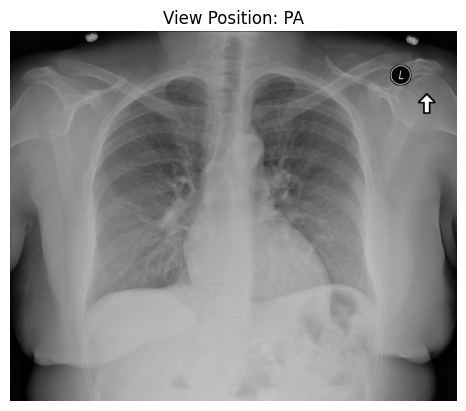

In [14]:
print(f"Image Shape: {image.pixel_array.shape}")
plt.imshow(image.pixel_array, cmap="gray")
plt.title(f"View Position: {image.ViewPosition}")
plt.axis(False)

In [16]:
image.pixel_array

array([[ 12,  12,  12, ...,  12,  12,  12],
       [ 18,  18,  19, ...,  18,  18,  18],
       [ 67,  68,  70, ...,  73,  73,  73],
       ...,
       [ 88,  87,  84, ..., 112, 119, 116],
       [ 86,  86,  86, ..., 117, 117, 119],
       [ 85,  86,  86, ..., 111, 115, 122]], dtype=uint16)

In [17]:
normalized = cv2.normalize(
    image.pixel_array,
    None,
    alpha=0,
    beta=255,
    norm_type=cv2.NORM_MINMAX,
    dtype=cv2.CV_8U,
)

In [18]:
normalized

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [5, 5, 5, ..., 7, 7, 7],
       [5, 5, 5, ..., 7, 7, 7],
       [5, 5, 5, ..., 7, 7, 7]], dtype=uint8)

In [19]:
# Define threshold
if image.PhotometricInterpretation == "MONOCHROME1":
    # Invert the image
    image = Image.fromarray((normalized).astype(np.uint8)).convert("L")
    image = ImageOps.invert(image)
else:
    image = Image.fromarray((normalized).astype(np.uint8)).convert("L")

# Resize the image to 224x224
image = image.resize((224, 224))

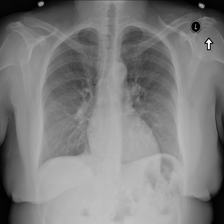

In [20]:
image

In [21]:
# Convert Image object to numpy array
image = np.array(image)

# # Normalize image
image = image.astype(np.float32) / 255.0

# Convert image to tensor
image = torch.from_numpy(image).unsqueeze(0)

In [22]:
image

tensor([[[0.0196, 0.0235, 0.0235,  ..., 0.0196, 0.0196, 0.0235],
         [0.0275, 0.0275, 0.0275,  ..., 0.0235, 0.0235, 0.0275],
         [0.0235, 0.0235, 0.0275,  ..., 0.0235, 0.0235, 0.0235],
         ...,
         [0.0196, 0.0196, 0.0157,  ..., 0.0275, 0.0275, 0.0275],
         [0.0196, 0.0196, 0.0157,  ..., 0.0275, 0.0275, 0.0275],
         [0.0196, 0.0196, 0.0157,  ..., 0.0275, 0.0275, 0.0275]]])

In [23]:
model = torch.load("C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/UNet_Full.pth")

C:\Users\DryLab\AppData\Local\Temp\ipykernel_31704\3625793086.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC

In [24]:
image = torch.tensor(np.array(image)).float()

model.eval()

with torch.no_grad():
    image = image.to("cuda")
    output = model(image.unsqueeze(0).float())

    output = output.argmax(dim=1).cpu().numpy().squeeze()

In [25]:
output.shape

(224, 224)

In [26]:
left_lung_mask = torch.from_numpy(output) == 1
right_lung_mask = torch.from_numpy(output) == 2
heart_mask = torch.from_numpy(output) == 3

In [27]:
left_lung_coords = torch.nonzero(left_lung_mask, as_tuple=False)
right_lung_coords = torch.nonzero(right_lung_mask, as_tuple=False)
heart_coords = torch.nonzero(heart_mask, as_tuple=False)

In [28]:
print(f"Left Lung Coords: {left_lung_coords}")
print(f"Right Lung Coords: {right_lung_coords}")
print(f"Heart Coords: {heart_coords}")

Left Lung Coords: tensor([[ 26,  76],
        [ 26,  77],
        [ 26,  78],
        ...,
        [169,  30],
        [170,  27],
        [170,  28]])
Right Lung Coords: tensor([[ 21, 143],
        [ 21, 144],
        [ 21, 145],
        ...,
        [172, 193],
        [172, 194],
        [172, 195]])
Heart Coords: tensor([[102, 121],
        [102, 122],
        [102, 123],
        ...,
        [166, 127],
        [166, 128],
        [166, 129]])


Text(0.5, 1.0, 'Heart Mask')

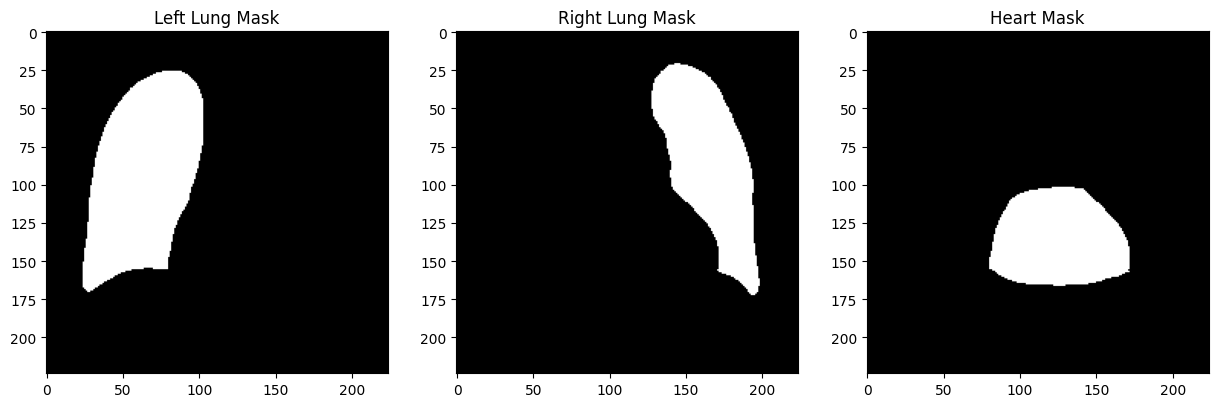

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(left_lung_mask.cpu().numpy(), cmap="gray")
plt.title("Left Lung Mask")

plt.subplot(1, 3, 2)
plt.imshow(right_lung_mask.cpu().numpy(), cmap="gray")
plt.title("Right Lung Mask")

plt.subplot(1, 3, 3)
plt.imshow(heart_mask.cpu().numpy(), cmap="gray")
plt.title("Heart Mask")

### Get Region Coord for Each Lung Region


In [30]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
class DICOMDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        dicom = dcmread(image_path)
        image = dicom.pixel_array

        # Convert 16-bit image to 8-bit image
        image = cv2.normalize(
            image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U
        )

        # Invert the image if the background is white
        if dicom.PhotometricInterpretation == "MONOCHROME1":
            image = Image.fromarray((image).astype(np.uint8)).convert("L")
            image = ImageOps.invert(image)
        else:
            image = Image.fromarray((image).astype(np.uint8)).convert("L")

        # Resize image
        image = image.resize((224, 224))

        # Convert Image object to numpy array
        image = np.array(image)

        # Normalize image
        image = image.astype(np.float32) / 255.0

        # Apply transform if exists
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]

        # Convert image to tensor
        image = torch.from_numpy(np.array(image)).unsqueeze(0).to(torch.float32)

        return image

In [32]:
image_paths_list = df["image_path"].tolist()

train_dataset = DICOMDataset(image_paths_list, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [33]:
img = next(iter(train_dataloader))

In [34]:
img.shape

torch.Size([32, 1, 224, 224])

In [35]:
model = torch.load(
    "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/UNet_Full.pth", map_location=device
)

C:\Users\DryLab\AppData\Local\Temp\ipykernel_31704\355142264.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(


In [36]:
def generate_segmentation_mask(model, dataloader, device):
    print(f"Segmenting images using {device}")
    model.eval()
    segmentation_results = []

    with torch.inference_mode():
        for batch, (images) in enumerate(tqdm(dataloader)):
            images = images.to(device)
            model = model.to(device)

            masks = model(images)
            masks = masks.argmax(dim=1).cpu().numpy()

            for i in range(images.shape[0]):
                image_id = batch * dataloader.batch_size + i
                segmentation_results.append((image_id, masks[i]))

    return segmentation_results

In [37]:
full_mask = generate_segmentation_mask(model, train_dataloader, device)

Segmenting images using cuda


  0%|          | 0/233 [00:00<?, ?it/s]

100%|██████████| 233/233 [05:12<00:00,  1.34s/it]


In [38]:
batch, mask = full_mask[0]
batch, mask.shape

(0, (224, 224))

In [39]:
df["image_size"] = [mask.shape for _, mask in full_mask]

C:\Users\DryLab\AppData\Local\Temp\ipykernel_31704\1367720079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["image_size"] = [mask.shape for _, mask in full_mask]


In [40]:
index = random.randint(0, len(df))

batch, mask = full_mask[index]

# Check min and max values
print(f"Min Value: {mask.min()}")
print(f"Max Value: {mask.max()}")

left_lung_mask = torch.from_numpy(mask) == 1
left_lung_mask.shape

Min Value: 0
Max Value: 3


torch.Size([224, 224])

In [48]:
# Swap False with 0
left_lung_mask = left_lung_mask.int()
left_lung_mask
# plt.imshow(left_lung_mask, cmap="gray")

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [49]:
left_lung_coords = torch.nonzero(left_lung_mask, as_tuple=False)
left_lung_coords.shape

torch.Size([6425, 2])

In [50]:
left_lung_coords.cpu().numpy()

array([[ 21,  99],
       [ 21, 100],
       [ 21, 101],
       ...,
       [163, 103],
       [163, 104],
       [164, 102]], dtype=int64)

Text(0.5, 1.0, 'torch.Size([224, 224])')

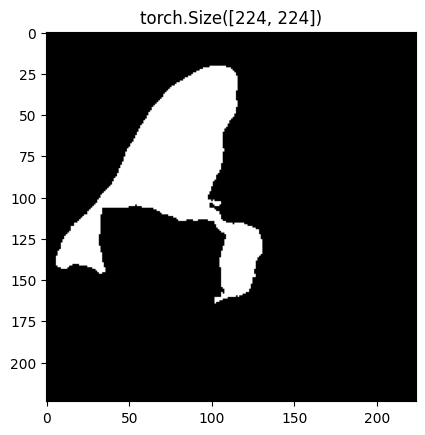

In [51]:
plt.imshow(left_lung_mask, cmap="gray")
plt.title(left_lung_mask.shape)

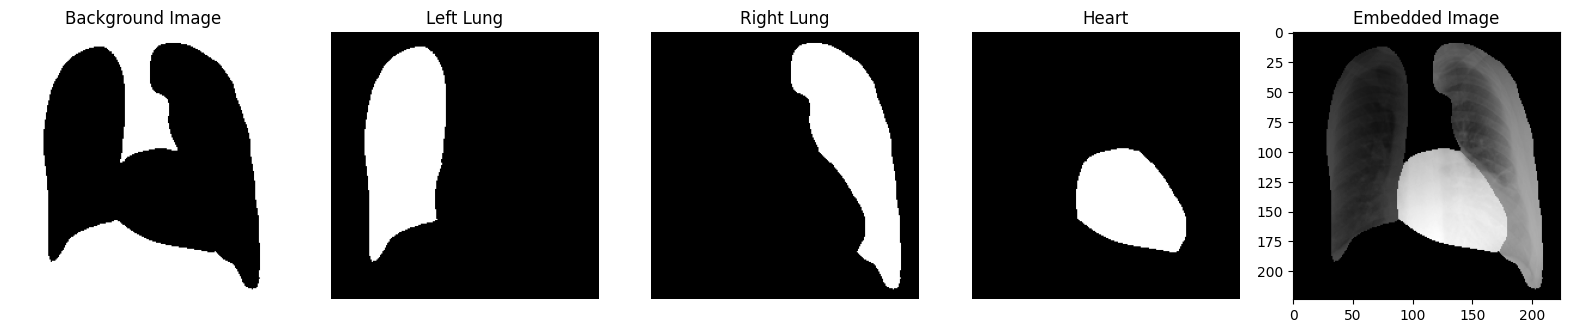

In [58]:
# Plot left lung, right lung, and heart coordinates for the first image
plt.figure(figsize=(20, 5))

index = random.randint(0, len(df))

plt.subplot(1, 5, 1)
plt.title("Background Image")
plt.imshow(full_mask[index][1] == 0, cmap="gray")
plt.axis(False)

plt.subplot(1, 5, 2)
plt.title("Left Lung")
plt.imshow(full_mask[index][1] == 1, cmap="gray")
plt.axis(False)

plt.subplot(1, 5, 3)
plt.title("Right Lung")
plt.imshow(full_mask[index][1] == 2, cmap="gray")
plt.axis(False)

plt.subplot(1, 5, 4)
plt.title("Heart")
plt.imshow(full_mask[index][1] == 3, cmap="gray")
plt.axis(False)

plt.subplot(1, 5, 5)
plt.title("Embedded Image")
plt.imshow(train_dataset[index].squeeze() * full_mask[index][1], cmap="gray")


plt.show()

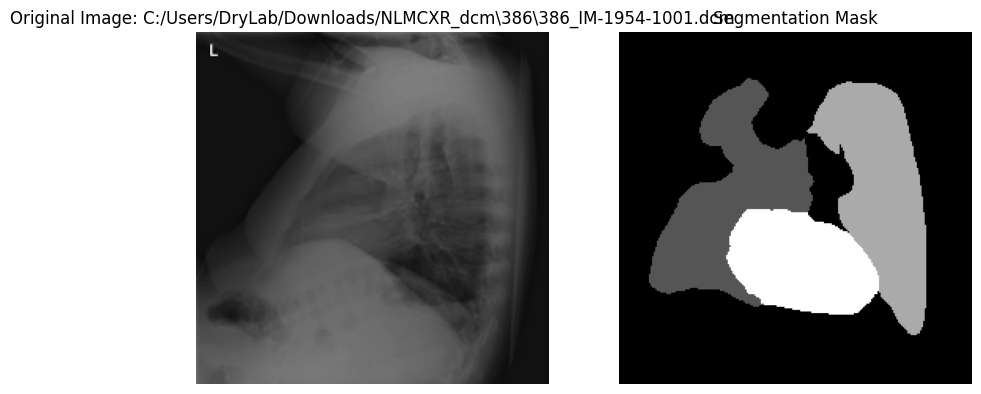

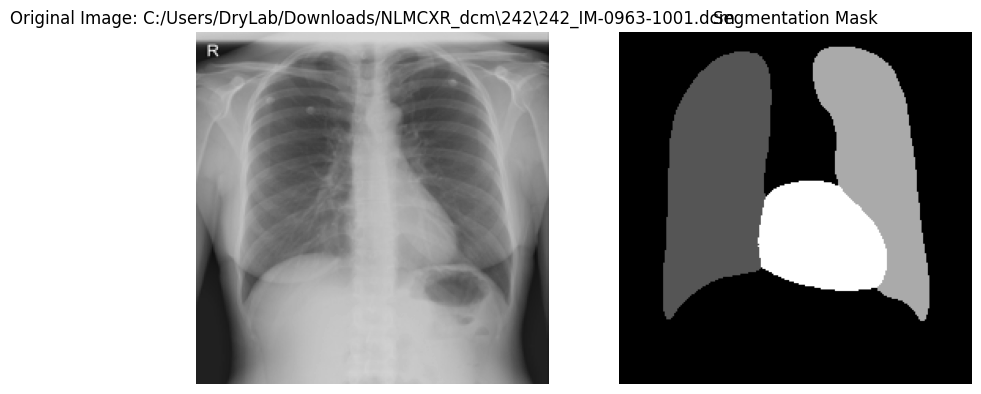

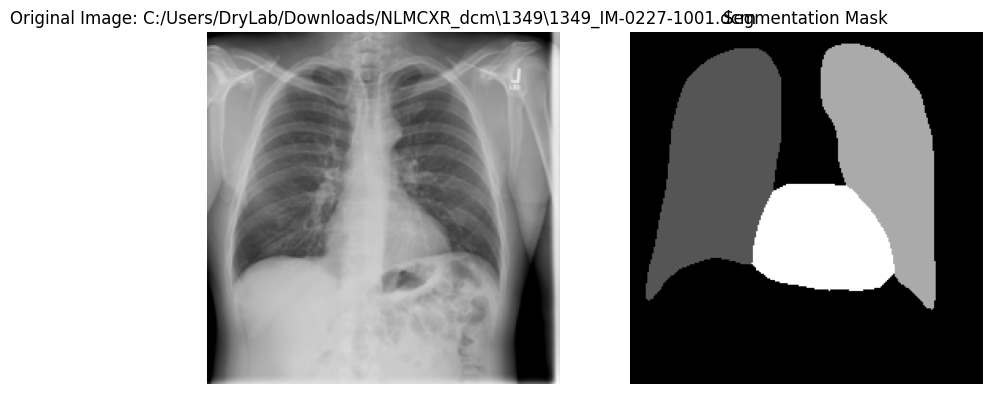

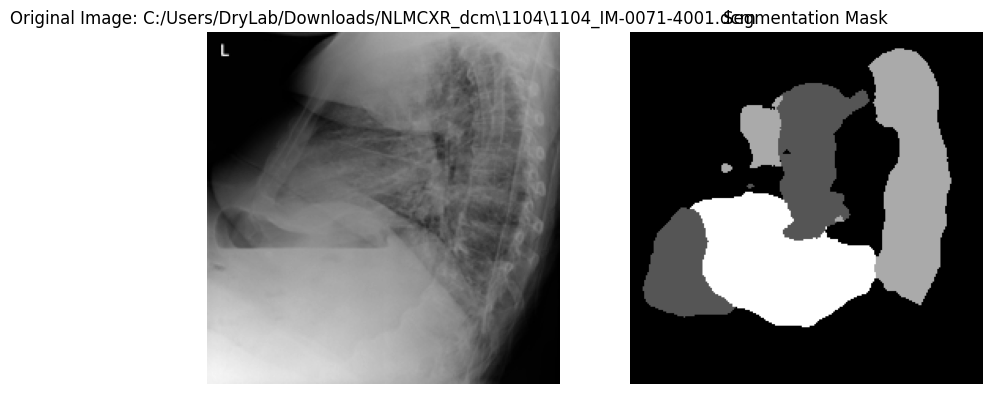

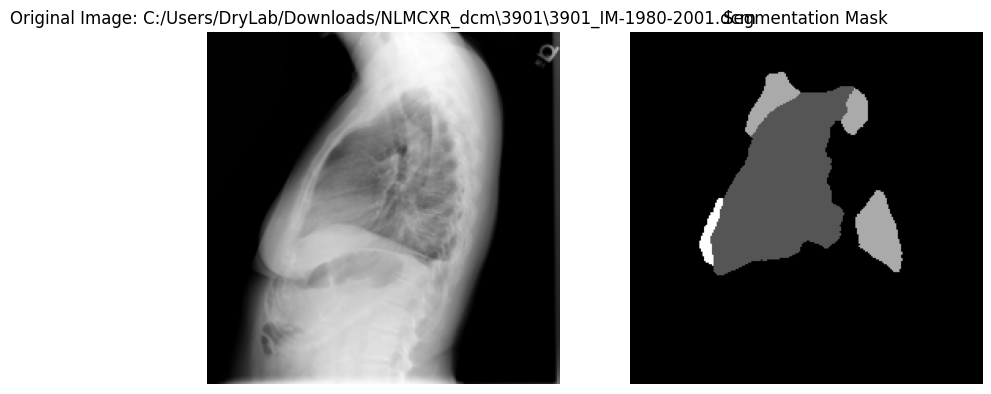

In [54]:
def visualize_segmentation_results(segmentation_results, dataset, num_samples=5):
    # Randomly sample a few segmentation results
    sample_results = random.sample(segmentation_results, num_samples)

    for index, mask in sample_results:
        # Load the corresponding image from the dataset
        original_image = (
            dataset[index][0].cpu().numpy()
        )  # Assuming the dataset returns (C, H, W)

        # Plot the original image and the segmentation mask
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f"Original Image: {dataset.image_paths[index]}")
        plt.imshow(original_image.squeeze(), cmap="gray")
        plt.axis(False)

        plt.subplot(1, 2, 2)
        plt.title("Segmentation Mask")
        plt.imshow(mask, cmap="gray")
        plt.axis(False)

        plt.show()


visualize_segmentation_results(full_mask, train_dataset, num_samples=5)


In [54]:
import torch
import numpy as np
import pandas as pd

# Initialize a list to store reg_coords for all images
all_reg_coords = []

for i in range(len(full_mask)):
    batch, mask = full_mask[i]

    # Convert mask to torch tensor for processing
    mask_tensor = torch.from_numpy(mask)

    # Create boolean masks for each organ
    left_lung_mask = mask_tensor == 1
    right_lung_mask = mask_tensor == 2
    heart_mask = mask_tensor == 3

    # Combine the coordinates into an array of arrays
    reg_coords = np.array(
        [
            left_lung_mask.cpu().numpy().astype(np.uint64).reshape(-1),
            right_lung_mask.cpu().numpy().astype(np.uint64).reshape(-1),
            heart_mask.cpu().numpy().astype(np.uint64).reshape(-1),
        ],
        dtype=object,
    )

    # Append to the list
    all_reg_coords.append(reg_coords)

In [1]:
# Check if all images has masks
len(all_reg_coords) == len(df)

NameError: name 'all_reg_coords' is not defined

In [56]:
# Add DataFrame Column with the coordinates of the masks
df["region_coord"] = all_reg_coords

C:\Users\DryLab\AppData\Local\Temp\ipykernel_8900\631136752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["region_coord"] = all_reg_coords


In [57]:
df["num_regions"] = df["region_coord"].apply(lambda x: len(x))

C:\Users\DryLab\AppData\Local\Temp\ipykernel_8900\3294767176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_regions"] = df["region_coord"].apply(lambda x: len(x))


In [75]:
df["region_coord"].iloc[0][0].reshape(224, 224)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [63]:
df

,image_id,image_path,text_path,image_size,region_coord,num_regions
0,0,C:/Users/DryLab/Downloads/NLMCXR_dcm\1\1_IM-00...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"(224, 224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
1,1,C:/Users/DryLab/Downloads/NLMCXR_dcm\1\1_IM-00...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"(224, 224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
6,6,C:/Users/DryLab/Downloads/NLMCXR_dcm\4\4_IM-20...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"(224, 224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
7,7,C:/Users/DryLab/Downloads/NLMCXR_dcm\4\4_IM-20...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"(224, 224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
10,10,C:/Users/DryLab/Downloads/NLMCXR_dcm\6\6_IM-21...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"(224, 224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
...,...,...,...,...,...,...
7459,7459,C:/Users/DryLab/Downloads/NLMCXR_dcm\3994\3994...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"(224, 224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
7464,7464,C:/Users/DryLab/Downloads/NLMCXR_dcm\3997\3997...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"(224, 224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
7466,7466,C:/Users/DryLab/Downloads/NLMCXR_dcm\3998\3998...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"(224, 224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
7468,7468,C:/Users/DryLab/Downloads/NLMCXR_dcm\3999\3999...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"(224, 224)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3


In [51]:
df.to_feather(f"{DATA_DIR}/annotations_medical.feather")

In [55]:
test_df = pd.read_feather(
    "C:/Users/DryLab/Desktop/ViLLA/data/docmnist_300000_29.5/annotations.feather"
)

In [60]:
# df = df[df['region_coord'].apply(lambda x: not any(len(mask) == 0 for mask in x))]

In [12]:
df = pd.read_feather(f"{DATA_DIR}/annotations.feather")

In [13]:
df

,image_id,image_path,text_path,image_size,region_coord,num_regions,text,attributes,split,sentences,region_labels
2606,2606,C:/Users/DryLab/Downloads/NLMCXR_dcm\1395\1395...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,lungs clear parenchymal infiltrates pulmonary ...,"[disease, edema, effusions]",train,[lungs clear parenchymal infiltrates pulmonary...,"[[1, 2, 3]]"
2631,2631,C:/Users/DryLab/Downloads/NLMCXR_dcm\1408\1408...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,stable right upper lobe calcified granuloma pn...,"[abnormality, consolidation, effusion, pneumot...",train,[stable right upper lobe calcified granuloma p...,"[[1, 2, 3]]"
6880,6880,C:/Users/DryLab/Downloads/NLMCXR_dcm\3689\3689...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,normal heart size mediastinal contours calcifi...,"[abnormality, disease, effusion, pneumothorax]",train,[normal heart size mediastinal contours calcif...,"[[1, 2, 3]]"
2503,2503,C:/Users/DryLab/Downloads/NLMCXR_dcm\1345\1345...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,heart size normal lungs clear xxxx normal pneu...,"[effusions, masses, nodules, pneumonia]",train,[heart size normal lungs clear xxxx normal pne...,"[[1, 2, 3]]"
6262,6262,C:/Users/DryLab/Downloads/NLMCXR_dcm\3369\3369...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,large pleural air collection present right med...,"[air, pneumothorax]",train,[large pleural air collection present right me...,"[[1, 2, 3]]"
...,...,...,...,...,...,...,...,...,...,...,...
5610,5610,C:/Users/DryLab/Downloads/NLMCXR_dcm\3024\3024...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,cardiomediastinal silhouette within normal lim...,"[abnormality, disease, effusion, limits, marki...",val,[cardiomediastinal silhouette within normal li...,"[[1, 2, 3]]"
3584,3584,C:/Users/DryLab/Downloads/NLMCXR_dcm\1919\1919...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,hyperexpansion lungs hyperlucency flattening h...,"[abnormality, atelectasis, disease, effusion, ...",val,[hyperexpansion lungs hyperlucency flattening ...,"[[1, 2, 3]]"
6740,6740,C:/Users/DryLab/Downloads/NLMCXR_dcm\3617\3617...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,cardiac silhouette mediastinal contours within...,"[disease, effusion, limits, opacity, pneumotho...",val,[cardiac silhouette mediastinal contours withi...,"[[1, 2, 3]]"
1805,1805,C:/Users/DryLab/Downloads/NLMCXR_dcm\966\966_I...,C:/Users/DryLab/Downloads/ecgen-radiology-txt\...,"[224, 224]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,cardiac silhouette normal size configuration m...,"[atelectasis, pneumothorax]",val,[cardiac silhouette normal size configuration ...,"[[1, 2, 3]]"


In [14]:
df["region_coord"].iloc[0][0].shape

(50176,)

In [186]:
def get_bounding_box(region_coords):
    # Find the indices where the region_label exists
    indices = np.nonzero(region_coords)

    # If there are no coordinates for the region_label, return None
    if len(indices[0]) == 0:
        return np.array([None, None, None, None])  # Placeholder for empty regions

    # Get the min and max x and y coordinates
    min_y, min_x = np.min(indices, axis=1)
    max_y, max_x = np.max(indices, axis=1)

    return np.array([min_x, min_y, max_x, max_y])


def process_row(region_coords, original_shape):
    # Reshape the region_coords to the original shape
    left_lung_coords = region_coords[0]  # Left Lung
    right_lung_coords = region_coords[1]  # Right Lung
    heart_coords = region_coords[2]  # Heart

    left_lung_2d = left_lung_coords.reshape(original_shape)
    right_lung_2d = right_lung_coords.reshape(original_shape)
    heart_2d = heart_coords.reshape(original_shape)

    # Calculate the bounding box for each region
    left_lung_bbox = get_bounding_box(left_lung_2d)
    right_lung_bbox = get_bounding_box(right_lung_2d)
    heart_bbox = get_bounding_box(heart_2d)

    # Concatenate all bounding boxes into a single 1D array
    region_bbox = np.array([left_lung_bbox, right_lung_bbox, heart_bbox], dtype=object)

    return region_bbox

In [187]:
original_shape = (224, 224)

# Apply function to each row
df["region_bbox"] = df["region_coord"].apply(lambda x: process_row(x, original_shape))

In [188]:
df["region_coord"].iloc[0]

array([array([0, 0, 0, ..., 0, 0, 0], dtype=uint64),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint64),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)], dtype=object)

In [189]:
df["region_bbox"].iloc[0]

array([[12, 25, 120, 180],
       [120, 28, 183, 177],
       [78, 111, 135, 178]], dtype=object)

In [206]:
df["region_bbox"].iloc[0][0]

array([12, 25, 120, 180], dtype=object)

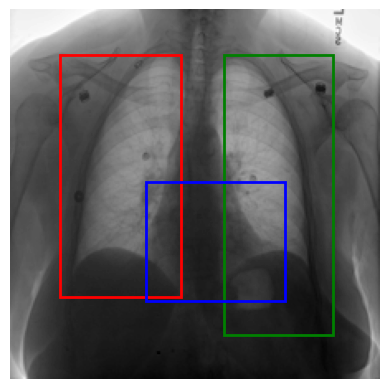

In [213]:
import matplotlib.patches as patches


def plot_bounding_boxes_for_index(
    df, index, image_column="image_path", bbox_column="region_bbox"
):
    # Load the image using the index
    image_path = df[image_column].iloc[index]
    dcm_image = dcmread(image_path).pixel_array

    # Normalize and resize the image
    image = cv2.normalize(
        dcm_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U
    )
    image = Image.fromarray(image).convert("L")
    image = image.resize((224, 224))

    # Extract the bounding boxes
    bounding_boxes = df[bbox_column].iloc[index]

    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap="gray")

    # Unpack the bounding boxes
    left_lung_bbox = bounding_boxes[0]
    right_lung_bbox = bounding_boxes[1]
    heart_bbox = bounding_boxes[2]

    # Define bounding boxes' colors
    colors = ["r", "g", "b"]  # Red for left lung, Green for right lung, Blue for heart

    # Create rectangles for each bounding box and add them to the plot
    for bbox, color in zip([left_lung_bbox, right_lung_bbox, heart_bbox], colors):
        if not np.array_equal(
            bbox, [0, 0, 0, 0]
        ):  # Skip if the bbox is just a placeholder
            rect = patches.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)

    # Hide axis and show the plot
    plt.axis(False)
    plt.show()


# Example usage
plot_bounding_boxes_for_index(df, index=3)
